In [ ]:
# Connect Faster GPUs
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jan  9 19:27:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Тестовое задание в ChemTech AI

Исполнитель: Кудюров Владислав

Задание
 - Используя данные представленные по ссылке Train_Data_200k создать модель, нацеленную на прогнозирование значений параметров Target_1...4 по значениям Tag_1...79.

 - После получения модели применить ее к тестовой выборке представленной в архиве ML_Data в файле test_data_100k и на основании значений Tag_1...79 получить прогнозы для параметров Target_1...4.

 - Полученные прогнозы и топ-10 значимых тэгов направить в качестве результата в ответном письме.


In [ ]:
!pip install catboost

In [ ]:
import catboost
print(f'Catboost version: {catboost.__version__}')

Catboost version: 0.24.4


In [ ]:
# Загружаем библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings

import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Указываем путь и название файлов
PATH = '/content/drive/My Drive/datasets/'
before_processing_train = 'train_data_200k.csv'
before_processing_test = 'test_data_100k.csv'


In [ ]:
# Настраиваем вывод колонок и строк в DataFrame
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200000

In [ ]:
# Загружаем тренировочные данные
train = pd.read_csv(PATH + before_processing_train)
test = pd.read_csv(PATH + before_processing_test)

In [ ]:
# Проверим размерность
print(f'train.shape={train.shape}')
print(f'test.shape={test.shape}')

train.shape=(200000, 84)
test.shape=(100000, 80)


In [ ]:
# Функция для отображения пропущенных данных
def get_heatmap(fn):
  try:
    cols = fn.columns
    colours = ['#000099', '#ffff00'] # желтый - пропущенные данные, синий - не пропущенные
    sns.heatmap(train[cols].isnull(), cmap=sns.color_palette(colours)) 
  except ValueError:
    print('Error DataFrame')

# Функция для вычисления процентного списка пропущенных данных
def get_persent(fn):
  try:
    for col in fn.columns:
      pct_missing = np.mean(fn[col].isnull())
      print('{} - {}%'.format(col, round(pct_missing*100)))
  except ValueError:
    print('Error DataFrame')


In [ ]:
# Переведем дату в индекс в обучающей выборке
train.index = pd.DatetimeIndex(train['Unnamed: 0'])
train = train.drop(['Unnamed: 0'], axis=1)
train = train.dropna(how='all', subset=['target1', 'target2', 'target3', 'target4'])


In [ ]:
# Посмотрим на колличество отсутствующих данных в обучающей выбоке
get_persent(train)

tag1 - 0%
tag2 - 45%
tag3 - 45%
tag4 - 100%
tag5 - 95%
tag6 - 100%
tag7 - 56%
tag8 - 92%
tag9 - 100%
tag10 - 0%
tag11 - 0%
tag12 - 0%
tag13 - 0%
tag14 - 0%
tag15 - 0%
tag16 - 0%
tag17 - 0%
tag18 - 0%
tag19 - 50%
tag20 - 0%
tag21 - 0%
tag22 - 0%
tag23 - 0%
tag24 - 0%
tag25 - 0%
tag26 - 0%
tag27 - 0%
tag28 - 0%
tag29 - 0%
tag30 - 0%
tag31 - 0%
tag32 - 0%
tag33 - 0%
tag34 - 0%
tag35 - 0%
tag36 - 80%
tag37 - 81%
tag38 - 21%
tag39 - 24%
tag40 - 92%
tag41 - 99%
tag42 - 0%
tag43 - 0%
tag44 - 44%
tag45 - 43%
tag46 - 51%
tag47 - 0%
tag48 - 34%
tag49 - 0%
tag50 - 61%
tag51 - 93%
tag52 - 49%
tag53 - 58%
tag54 - 70%
tag55 - 0%
tag56 - 0%
tag57 - 0%
tag58 - 0%
tag59 - 0%
tag60 - 0%
tag61 - 82%
tag62 - 82%
tag63 - 0%
tag64 - 0%
tag65 - 0%
tag66 - 0%
tag67 - 0%
tag68 - 0%
tag69 - 81%
tag70 - 0%
tag71 - 0%
tag72 - 0%
tag73 - 82%
tag74 - 0%
tag75 - 0%
tag76 - 0%
tag77 - 76%
tag78 - 76%
tag79 - 76%
target1 - 0%
target2 - 0%
target3 - 0%
target4 - 0%


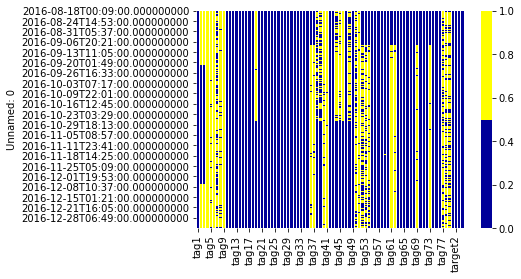

In [ ]:
# Построим матрицу корреляции данных обучающей выборки
get_heatmap(train)

In [ ]:
# Посмотрим на колличество отсутствующих данных в тестовой выбоке
get_persent(test)

tag1 - 0%
tag2 - 100%
tag3 - 100%
tag4 - 100%
tag5 - 85%
tag6 - 100%
tag7 - 85%
tag8 - 77%
tag9 - 100%
tag10 - 0%
tag11 - 0%
tag12 - 0%
tag13 - 0%
tag14 - 0%
tag15 - 0%
tag16 - 0%
tag17 - 0%
tag18 - 0%
tag19 - 0%
tag20 - 0%
tag21 - 0%
tag22 - 0%
tag23 - 0%
tag24 - 0%
tag25 - 0%
tag26 - 0%
tag27 - 0%
tag28 - 0%
tag29 - 0%
tag30 - 0%
tag31 - 0%
tag32 - 0%
tag33 - 0%
tag34 - 0%
tag35 - 0%
tag36 - 96%
tag37 - 97%
tag38 - 0%
tag39 - 0%
tag40 - 95%
tag41 - 100%
tag42 - 0%
tag43 - 0%
tag44 - 0%
tag45 - 0%
tag46 - 0%
tag47 - 0%
tag48 - 0%
tag49 - 0%
tag50 - 69%
tag51 - 93%
tag52 - 74%
tag53 - 67%
tag54 - 79%
tag55 - 0%
tag56 - 0%
tag57 - 0%
tag58 - 0%
tag59 - 0%
tag60 - 0%
tag61 - 98%
tag62 - 98%
tag63 - 0%
tag64 - 0%
tag65 - 0%
tag66 - 0%
tag67 - 0%
tag68 - 0%
tag69 - 97%
tag70 - 0%
tag71 - 0%
tag72 - 0%
tag73 - 98%
tag74 - 0%
tag75 - 0%
tag76 - 0%
tag77 - 75%
tag78 - 75%
tag79 - 11%


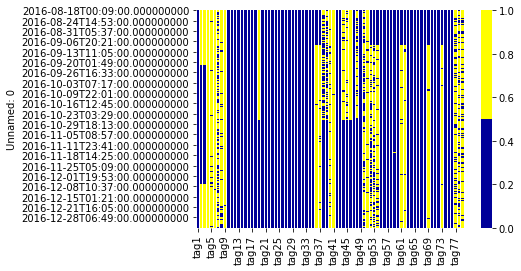

In [ ]:
# Построим матрицу корреляции данных тестовой выборки
get_heatmap(test)

In [ ]:
# Разделим на X и Y
X_train = train.drop(['target1', 'target2', 'target3', 'target4'], axis=1)
Y_train = train[['target1', 'target2', 'target3', 'target4']]

In [ ]:
# Кросс-валидация-sklearn.model_selection.TimeSeriesSplit, так как временная последовательность
tscv = TimeSeriesSplit(n_splits=10)
# Гиперпараметры
param_grid = {'learning_rate': [0.03, 0.06, 0.1], 'depth': [4, 6, 8], 'l2_leaf_reg': [3, 5, 7]}
# модель - CatBoostRegressor
model = CatBoostRegressor(loss_function='MultiRMSE', nan_mode='Min', silent=True)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv)

In [ ]:
# Обучение модели
history = grid_search.fit(X_train, Y_train, verbose=1000)

0:	learn: 0.0049624	total: 19.3ms	remaining: 19.3s
999:	learn: 0.0004406	total: 16.7s	remaining: 0us
0:	learn: 0.0048573	total: 32.3ms	remaining: 32.3s
999:	learn: 0.0007188	total: 25.4s	remaining: 0us
0:	learn: 0.0047478	total: 48ms	remaining: 48s
999:	learn: 0.0008547	total: 36.5s	remaining: 0us
0:	learn: 0.0051626	total: 63.6ms	remaining: 1m 3s
999:	learn: 0.0009664	total: 46.9s	remaining: 0us
0:	learn: 0.0053317	total: 76.8ms	remaining: 1m 16s
999:	learn: 0.0010531	total: 54.5s	remaining: 0us
0:	learn: 0.0055048	total: 90.4ms	remaining: 1m 30s
999:	learn: 0.0010795	total: 1m 5s	remaining: 0us
0:	learn: 0.0055375	total: 97.9ms	remaining: 1m 37s
999:	learn: 0.0011350	total: 1m 14s	remaining: 0us
0:	learn: 0.0054764	total: 118ms	remaining: 1m 57s
999:	learn: 0.0011736	total: 1m 25s	remaining: 0us
0:	learn: 0.0053273	total: 124ms	remaining: 2m 4s
999:	learn: 0.0011736	total: 1m 36s	remaining: 0us
0:	learn: 0.0052190	total: 140ms	remaining: 2m 19s
999:	learn: 0.0011740	total: 1m 44s	rem

In [ ]:
# Выведем лучший результат
best_result = grid_search.best_params_
print(f"Параметры лучшей модели: {best_result}")

Параметры лучшей модели: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [ ]:
# Лучший результат, по результатам кросс-валидации
best_score = grid_search.best_estimator_.best_score_
print(f"Оценка на обучающем наборе: {best_score}")

Оценка на обучающем наборе: {'learn': {'MultiRMSE': 0.000904196600998854}}


In [ ]:
# Переведем дату в индекс в тестовой выборке
test.index = pd.DatetimeIndex(test['Unnamed: 0'])
test = test.drop(['Unnamed: 0'], axis=1)

In [ ]:
# Проверим на тестовой выборке
predicted = pd.DataFrame(grid_search.best_estimator_.predict(test), columns=Y_train.columns, index=test.index)
predicted.head(10)

,target1,target2,target3,target4
Unnamed: 0,,,,
2017-01-03 21:21:00,0.001484,0.063980,0.930197,0.004339
2017-01-03 21:22:00,0.001499,0.064600,0.929521,0.004380
2017-01-03 21:23:00,0.001492,0.064321,0.929820,0.004367
2017-01-03 21:24:00,0.001489,0.064178,0.929959,0.004373
2017-01-03 21:25:00,0.001489,0.064193,0.929938,0.004380
2017-01-03 21:26:00,0.001484,0.063957,0.930173,0.004387
2017-01-03 21:27:00,0.001492,0.064293,0.929851,0.004364
2017-01-03 21:28:00,0.001483,0.063930,0.930201,0.004387
2017-01-03 21:29:00,0.001487,0.064086,0.930050,0.004378


In [ ]:
# Сохраним полученный результат
predicted.to_csv(PATH + 'test_ChemTech.csv')

Анализируем полученный результат

In [ ]:
feature_name = pd.DataFrame(data=[grid_search.best_estimator_.feature_names_, 
                                            grid_search.best_estimator_.feature_importances_]).T
feature_name.columns = ['tags', 'importance']
feature_name

,tags,importance
0,tag1,0.304727
1,tag2,0.00834875
2,tag3,0.117562
3,tag4,0
4,tag5,0.000386115
5,tag6,0
6,tag7,0.216245
7,tag8,0.00263723
8,tag9,0
9,tag10,0.042006


In [ ]:
# Сохраним 10 первых признаков
feature_ratio = feature_name.sort_values(by='importance', ascending=False)
feature_ratio.head(10).to_csv(PATH + 'test_10result')

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.bar(feature_ratio, y='importance', x='tags', text='tags')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig.show()